# Set up

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from PIL import ImageFile
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Number of GPUs available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs available:  0


## Data Preparation

In [32]:
train_path = 'skin_disease/train'
valid_path = 'skin_disease/valid'
test_path = 'skin_disease/test'
dark_skinned_path = 'skin_disease/dark_skinned'

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [34]:
print(dark_skinned_path)

skin_disease/dark_skinned


In [50]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(train_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(valid_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(test_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10, shuffle=False)
dark_skinned_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(dark_skinned_path, target_size=(224,224), classes=['melanoma'], batch_size=10, shuffle=False)

Found 7530 images belonging to 2 classes.
Found 1505 images belonging to 2 classes.
Found 925 images belonging to 2 classes.
Found 99 images belonging to 1 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
#         ax.axes('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

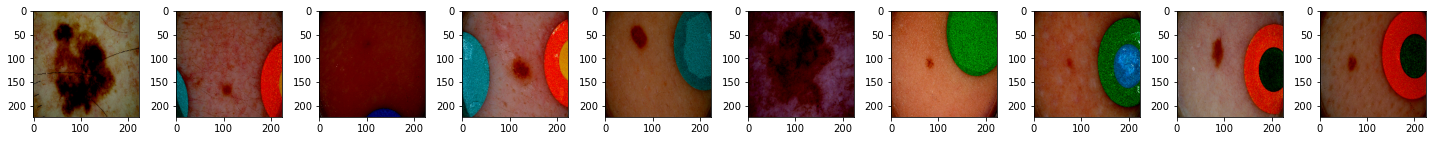

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
plotImages(imgs)
print(labels)

## Build Fine-tuned InceptionV3 model

In [9]:
inception_v3_model = keras.applications.InceptionV3()

In [10]:
bottleneck_input  = inception_v3_model.get_layer(index=0).input
bottleneck_output = inception_v3_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

In [11]:
bottleneck_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
for layer in bottleneck_model.layers:
    layer.trainable = False

In [14]:
bottleneck_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
model = Sequential()
model.add(bottleneck_model)
model.add(Dense(2, activation='softmax', input_dim=2048))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the fine-tuned InceptionV3 model

In [17]:
model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
753/753 - 2158s - loss: 0.2311 - accuracy: 0.9060 - val_loss: 0.1638 - val_accuracy: 0.9289
Epoch 2/5
753/753 - 2160s - loss: 0.1353 - accuracy: 0.9440 - val_loss: 0.1408 - val_accuracy: 0.9455
Epoch 3/5
753/753 - 2147s - loss: 0.1216 - accuracy: 0.9502 - val_loss: 0.1161 - val_accuracy: 0.9588
Epoch 4/5
753/753 - 2153s - loss: 0.1125 - accuracy: 0.9537 - val_loss: 0.1119 - val_accuracy: 0.9608
Epoch 5/5
753/753 - 2153s - loss: 0.1066 - accuracy: 0.9551 - val_loss: 0.1505 - val_accuracy: 0.9362


In [19]:
model.save('NevusVsMelanoma')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: NevusVsMelanoma\assets


## Predict using fine-tuned InceptionV3 model

In [20]:
predictions = model.predict(x=test_batches, verbose=0)

In [21]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [69]:
cm

array([[158,  19],
       [  1, 747]], dtype=int64)

In [23]:
test_batches.class_indices

{'melanoma': 0, 'nevus': 1}

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[158  19]
 [  1 747]]


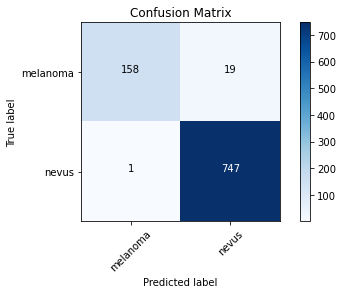

In [25]:
cm_plot_labels = ['melanoma','nevus']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Predict dark-skinned Melanoma using fine-tuned InceptionV3 model

In [51]:
dark_skinned_predictions = model.predict(x=dark_skinned_batches, verbose=0)

In [71]:
dark_skinned_batches.class_indices

{'melanoma': 0}

In [53]:
dark_cm = confusion_matrix(y_true=dark_skinned_batches.classes, y_pred=np.argmax(dark_skinned_predictions, axis=-1))

Confusion matrix, without normalization
[[75 24]
 [ 0  0]]


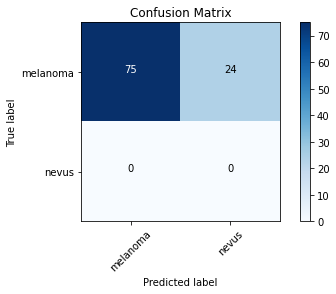

In [56]:
dark_cm_plot_labels = ['melanoma','nevus']
plot_confusion_matrix(dark_cm, dark_cm_plot_labels, title='Confusion Matrix')

## Retrain InceptionV3 model with dark skinned data included

In [57]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(train_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(valid_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(test_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10, shuffle=False)
dark_skinned_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(dark_skinned_path, target_size=(224,224), classes=['melanoma'], batch_size=10, shuffle=False)

Found 7539 images belonging to 2 classes.
Found 1505 images belonging to 2 classes.
Found 925 images belonging to 2 classes.
Found 90 images belonging to 1 classes.


In [58]:
new_model = Sequential()
new_model.add(bottleneck_model)
new_model.add(Dense(2, activation='softmax', input_dim=2048))

In [59]:
new_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(train_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
new_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(valid_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10)
new_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(test_path, target_size=(224,224), classes=['melanoma', 'nevus'], batch_size=10, shuffle=False)
new_dark_skinned_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(dark_skinned_path, target_size=(224,224), classes=['melanoma'], batch_size=10, shuffle=False)

Found 7539 images belonging to 2 classes.
Found 1505 images belonging to 2 classes.
Found 925 images belonging to 2 classes.
Found 90 images belonging to 1 classes.


In [60]:
new_model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
new_model.fit(x=new_train_batches, validation_data=new_valid_batches, epochs=5, verbose=2)

Epoch 1/5
754/754 - 2045s - loss: 0.2259 - accuracy: 0.9062 - val_loss: 0.1668 - val_accuracy: 0.9322
Epoch 2/5
754/754 - 2154s - loss: 0.1414 - accuracy: 0.9398 - val_loss: 0.1856 - val_accuracy: 0.9189
Epoch 3/5
754/754 - 2356s - loss: 0.1239 - accuracy: 0.9487 - val_loss: 0.1113 - val_accuracy: 0.9608
Epoch 4/5
754/754 - 2237s - loss: 0.1155 - accuracy: 0.9521 - val_loss: 0.1340 - val_accuracy: 0.9475
Epoch 5/5
754/754 - 2127s - loss: 0.1085 - accuracy: 0.9554 - val_loss: 0.1750 - val_accuracy: 0.9249


In [62]:
new_model.save('NewNevusVsMelanoma')

INFO:tensorflow:Assets written to: NewNevusVsMelanoma\assets


## Predict using retrained and fine-tuned InceptionV3 model

In [63]:
new_predictions = new_model.predict(x=new_test_batches, verbose=0)

In [64]:
new_cm = confusion_matrix(y_true=new_test_batches.classes, y_pred=np.argmax(new_predictions, axis=-1))

Confusion matrix, without normalization
[[148  29]
 [  0 748]]


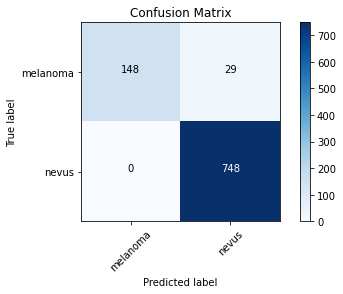

In [65]:
new_cm_plot_labels = ['melanoma','nevus']
plot_confusion_matrix(new_cm, new_cm_plot_labels, title='Confusion Matrix')

## Predict dark-skinned Melanoma using fine-tuned InceptionV3 model

In [66]:
new_dark_skinned_predictions = new_model.predict(x=new_dark_skinned_batches, verbose=0)

In [67]:
new_dark_cm = confusion_matrix(y_true=new_dark_skinned_batches.classes, y_pred=np.argmax(new_dark_skinned_predictions, axis=-1))

Confusion matrix, without normalization
[[68 22]
 [ 0  0]]


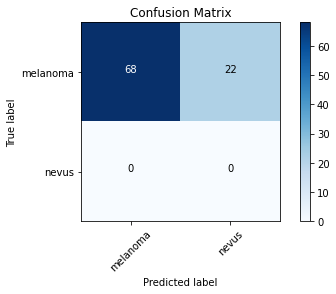

In [68]:
new_dark_cm_plot_labels = ['melanoma','nevus']
plot_confusion_matrix(new_dark_cm, new_dark_cm_plot_labels, title='Confusion Matrix')